In [1]:
#Final Program

#Imports
import requests
import json
import math
import datetime
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pytz import timezone
import time
import copy
from IPython.display import clear_output
import os

#Initial Parameters
optionChainLink = "https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY"
header_para = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36'}
India_Time = timezone('Asia/Calcutta')  
timeOfData = []
strikePrices = []
filteredDict = defaultdict(dict)
Difference = defaultdict(list)
dataframe_list = []
graphData = defaultdict(list)
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
dataframe_list = [df1, df2, df3, df4]
totalDifference = defaultdict(list)
totalDifference_1 = defaultdict(list)
totalDifference_2 = defaultdict(list)
totalDifference_3 = defaultdict(list)
totalDifference_4 = defaultdict(list)
td_list = [totalDifference_1,totalDifference_2,totalDifference_3,totalDifference_4]
sumTotalPE = 0
sumTotalCE = 0
ten_min_trigger = 0
run = 0
nifty_price = []

Current Nifty : 24412.05



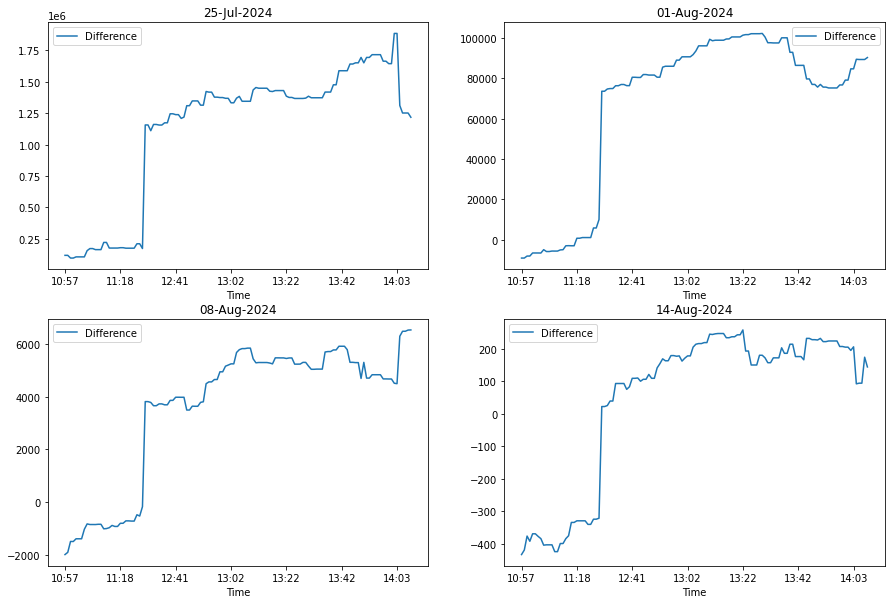

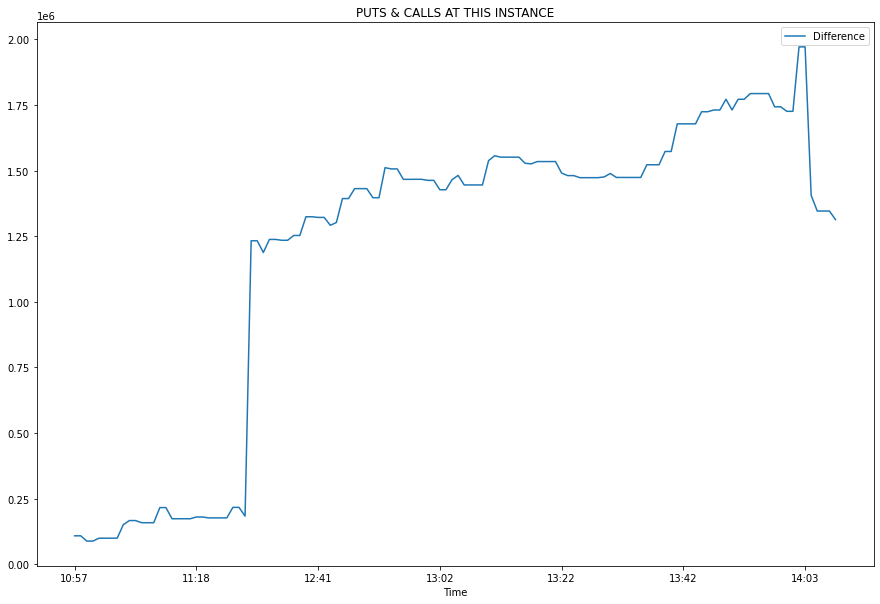

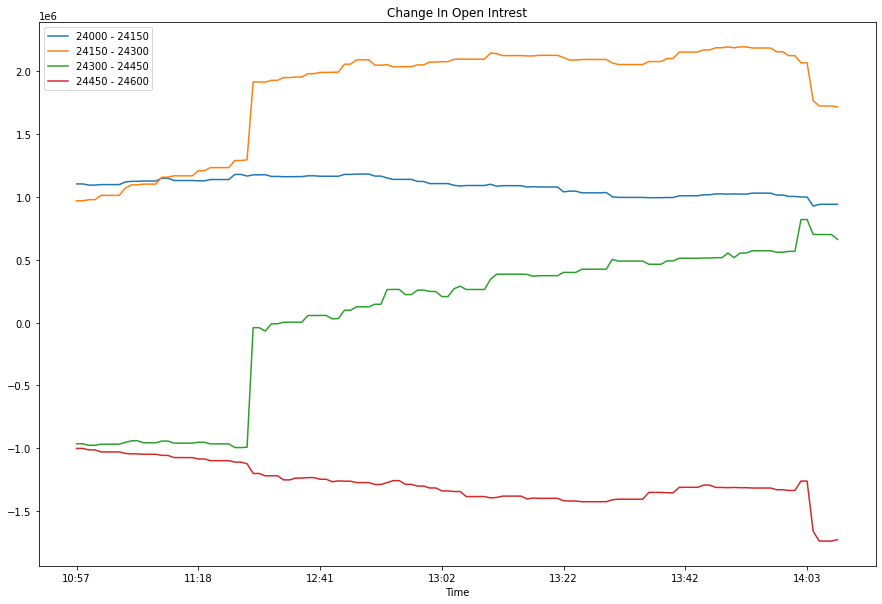

      Time  Difference
0    10:57      108368
1    10:58      108466
2    10:59       88318
3    11:01       88300
4    11:02       99291
..     ...         ...
121  14:33     1405461
122  14:35     1345888
123  14:35     1345888
124  14:38     1346013
125  14:39     1313042

[126 rows x 2 columns]


In [ ]:
def showGraph():
    plt.show()
    
def saveData():
    if not os.path.exists(datetime.datetime.now().strftime('%d%b%y')):
        os.mkdir(datetime.datetime.now().strftime('%d%b%y'))
    fig.savefig(datetime.datetime.now().strftime('%d%b%y') + "/Figures")

    master_fig = master.get_figure()
    master_fig.savefig(datetime.datetime.now().strftime('%d%b%y') + "/Master")
    
    master_2_fig = master_2.get_figure()
    master_2_fig.savefig(datetime.datetime.now().strftime('%d%b%y') + "/Master_2")

    writer = pd.ExcelWriter(datetime.datetime.now().strftime('%d%b%y') + "/Data.xlsx")
    for i in range(len(dataframe_list)):
        pd.DataFrame(dataframe_list[i], columns=['Time','Difference']).to_excel(writer, expiryDates[i])
    pd.DataFrame(totalDifference, columns=['Time', 'Difference']).to_excel(writer, 'Change In OI')
    writer.save()

#Interval of 5 minutes
while True:
    #Fetch Data from API to JSON
    data = None
    while data is None:
        try:
            with requests.session() as s:
                data = s.get(optionChainLink, headers = header_para).json()
                raw_data = json.dumps(data)
            option = json.loads(raw_data)
        except:
            pass

    
    if run == 0:
        currentNifty = option['records']['underlyingValue']
        new = currentNifty/100
        upper_range = (int(new)*100) + 300
        lower_range = (int(new)*100) - 300
        strikePrices = [strike for strike in option['records']['strikePrices'] if lower_range <= strike <= upper_range]
        strikePrice_1 = [strike for strike in option['records']['strikePrices'] if lower_range <= strike <= lower_range + 150]
        strikePrice_2 = [strike for strike in option['records']['strikePrices'] if lower_range + 150 <= strike <= lower_range + 300]
        strikePrice_3 = [strike for strike in option['records']['strikePrices'] if upper_range - 300 <= strike <= upper_range - 150]
        strikePrice_4 = [strike for strike in option['records']['strikePrices'] if upper_range - 150 <= strike <= upper_range]
        combine_strikePrice = [strikePrice_1, strikePrice_2, strikePrice_3, strikePrice_4]
        run = run + 1
    
    #Current Nifty Price
    currentNifty = option['records']['underlyingValue']
    nifty_price.append(currentNifty)

    #Getting expiry dates from dict
    expiryDates = option['records']['expiryDates'][:9]

    #Time of Data Received
    timeOfData.append(option['records']['timestamp'][-8:-3])

    #Date of the Data
    dateOfData = option['records']['timestamp'][:11]

    #Change in OI for Overall Range
    for block in option['records']['data'][:]:
        if block['strikePrice'] in strikePrices and block['expiryDate'] in expiryDates:
            date = block['expiryDate']
            sp = str(block['strikePrice'])
            try:
                pe = block['PE']['changeinOpenInterest']
                pe_oi = block['PE']['openInterest']
            except:
                pe = 0
                pe_oi = 0
            try:
                ce = block['CE']['changeinOpenInterest']
                ce_oi = block['CE']['openInterest']
            except:
                ce = 0
                ce_oi = 0
            filteredDict[date][sp] = {'PE': pe ,'CE': ce,'PE_OI': pe_oi ,'CE_OI': ce_oi}
            
    #Change in OI for 4 Ranges
    td_counter = 0
    for i in combine_strikePrice:
        total_pe = 0
        total_ce = 0
        for block in option['records']['data'][:]:
            if block['strikePrice'] in i and block['expiryDate'] in expiryDates:
                date = block['expiryDate']
                sp = str(block['strikePrice'])
                try:
                    pe = block['PE']['changeinOpenInterest']
                    total_pe = total_pe + pe
                except:
                    pe = 0
                try:
                    ce = block['CE']['changeinOpenInterest']
                    total_ce = total_ce + ce
                except:
                    ce = 0
        td_list[td_counter]['Difference'].append(total_pe - total_ce)
        td_list[td_counter]['Time'] = timeOfData
        td_list[td_counter]['Nifty'] = nifty_price
        td_counter = td_counter + 1

    common_df = pd.DataFrame(timeOfData, columns=["Time"])
    for i in range(4):
        common_df[str(combine_strikePrice[i][0]) + " - " + str(combine_strikePrice[i][-1])] = td_list[i]['Difference']
    
    #Forming Graph for selected Date in Grid
    dataframeCounter = 0
    for selected_date in expiryDates[:4]:
        selectedDict = filteredDict[selected_date]
        datePE = [selectedDict[str(i)]['PE'] for i in strikePrices]
        dateCE = [selectedDict[str(i)]['CE'] for i in strikePrices]
        Difference[selected_date].append(sum(datePE) - sum(dateCE))
        graphData['Time'] = timeOfData
        graphData['Difference'] = Difference[selected_date]
        dataframe_list[dataframeCounter] = copy.deepcopy(graphData)
        dataframeCounter = dataframeCounter + 1

    #Formation of Pie Chart
    totalPE = [filteredDict[i][str(j)]['PE'] for i in expiryDates[:4] for j in strikePrices]
    totalCE = [filteredDict[i][str(j)]['CE'] for i in expiryDates[:4] for j in strikePrices]
    
    #Total Strike Price and Expiry Puts and Calls
    totalDifference['Difference'].append(sum(totalPE) - sum(totalCE))
    totalDifference['Time'] = timeOfData
    totalDifference['Nifty'] = nifty_price

    #Show Change in OI Graph
    fig, axes = plt.subplots(2, 2,figsize=(15,10))

    count = 0
    for r in [0,1]:
        for c in [0,1]:
            pd.DataFrame(dataframe_list[count]).plot(ax=axes[r,c], title = expiryDates[count],x = 'Time', y = 'Difference')
            count = count + 1
        
    master = pd.DataFrame(totalDifference, columns=['Time', 'Difference']).plot(title="PUTS & CALLS AT THIS INSTANCE",x = 'Time', y='Difference', figsize=(15,10))
    master_2 = common_df.plot(title = "Change In Open Intrest", x = "Time", y = common_df.columns.tolist()[1:], figsize=(15,10))



    
    if datetime.datetime.now(India_Time).strftime("%H:%M") > '15:30':
        showGraph()
        saveData()
        print('Market Closed')
        break
        
    clear_output(wait=True)
    
    print(f"Current Nifty : {currentNifty}\n")
    
    showGraph()  
    print(pd.DataFrame(totalDifference, columns=['Time', 'Difference']))
    
    time.sleep(60)

In [ ]:
saveData()